### Fill in your name, student id number and email address
#### name: Jeremias Shadbolt
#### student id: 1900386
#### email: jrshad@utu.fi

## Data analysis and knowledge discovery - Exercise 3: Unsupervised learning

This is the template for the third exercise. The purpose of this exercise is to familiarize yourself with the basics of unsupervised learning by using the agglomerative hierarchical clustering and k-means clustering algorithms to find patterns.

The data set utilised in this exercise is a simplified and downsampled version of a knowledge discovery and data mining competition data set. The data will be available on the course's Moodle page. For those who are interested, the original data can be found at https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html. However, please make sure to **use the version on Moodle** as `ex3_network_data.csv`. The data is described below.

The data set contains samples of network activity simulated in a military network environment. There are different types of malicious activity, and also activity that is considered normal. It is **not necessary** to understand the details of the data set in order to complete the exercise.

In addition to normal activity, there are 3 types of malicious activity - denial of service, unauthorized remote login, and network probing (e.g. port scanning) - simulated in a military network environment. There are 500 samples of each class. There are 6 numeric features, described below:

`src_bytes`: number of bytes from source to destination\
`dst_bytes`: number of bytes from destination to source\
`duration`: length of connection (seconds)\
`count`: number of connections to the same host as the current connection in the past two seconds\
`serror_rate`: percentage of connections that have SYN errors\
`rerror_rate`: percentage of connections that have REJ errors

In real applications, visualizing and cleaning the data are important steps. However, in this exercise you can treat the data as given, and focus on the unsupervised methods.

Please consider the following things when returning your notebook:

 - As in the two previous exercises, the grading scale is failed/passed/passed with honors.
 
 - For a passing grade each part of the exercise, except for the BONUS, must be completed, and all questions should be answered. Some mistakes are allowed as long as you clearly attempt to solve all the exercises.
 
 - For doing both the exercise and the optional bonus task sufficiently well, you will be awarded one bonus point for the exam.
 
 - All the cells in the finished notebook should run without crashing. Please delete unnecessary cells. As a good rule of thumb, use "Restart and run all" on the finished notebook to make sure it runs without errors and produces the expected output.

 - Remember to comment your code to explain how it works and what you intend for it to do.
 
 - Answer the questions asked in the assignments in Markdown cells.
 
 - If you are having problems with this exercise, try an online search first, but don't just copy-paste any code you find. See exercise guidelines in the Moodle page of this course. If you can't find a solution to your problem, ask for advice in the course discussion forum on Moodle or contact oskari.s.heikkinen@utu.fi.
 
 - If/when you look things up during this exercise, please cite your sources (e.g. a link to a web page). It's better to cite too much than too little.

### Library imports, Jupyter Notebook settings etc.

The below libraries are sufficient to complete the exercise. You can import additional functionality here if you want.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline

### Read the data

- Download the exercise 3 data on the Moodle page of this course.
- Read the data into a Pandas dataframe.
- Display a few rows and some basic information to make sure the data was loaded correctly

In [27]:
# read data into df
data = pd.read_csv('ex3_network_data.csv')

In [28]:
# verify
display(data.head()) # first 5 rows
display(data.describe()) # base statistics for numerics
display(data['class'].describe()) # base stats for targets
display(data.dtypes) # data types
display(data['class'].unique()) # target variables
display(data.isna().sum()) #NaNs

,src_bytes,dst_bytes,duration,count,serror_rate,rerror_rate,class
0,0,0,0,223,1.0,0.0,denial_of_service
1,1032,0,0,511,0.0,0.0,denial_of_service
2,520,0,0,511,0.0,0.0,denial_of_service
3,1032,0,0,510,0.0,0.0,denial_of_service
4,520,0,0,448,0.0,0.0,denial_of_service


,src_bytes,dst_bytes,duration,count,serror_rate,rerror_rate
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.00000
mean,402.324500,382.56600,20.246500,111.158000,0.059415,0.14014
std,464.815917,861.81793,241.867267,198.399713,0.234554,0.34661
min,0.000000,0.00000,0.000000,1.000000,0.000000,0.00000
25%,8.000000,0.00000,0.000000,1.000000,0.000000,0.00000
50%,286.500000,0.00000,0.000000,2.000000,0.000000,0.00000
75%,748.000000,146.00000,0.000000,105.250000,0.000000,0.00000
max,4703.000000,4982.00000,4776.000000,511.000000,1.000000,1.00000


count       2000
unique         4
top       normal
freq         500
Name: class, dtype: object

src_bytes        int64
dst_bytes        int64
duration         int64
count            int64
serror_rate    float64
rerror_rate    float64
class           object
dtype: object

array(['denial_of_service', 'normal', 'probe',
       'unauthorized_remote_login'], dtype=object)

src_bytes      0
dst_bytes      0
duration       0
count          0
serror_rate    0
rerror_rate    0
class          0
dtype: int64

### Part 1: Preprocess and visualize the data

 - Perform z-score standardization on the features to ensure that all features have the same scale.
 
 - Project the data to two dimensions by using principal component analysis (PCA) and visualize the resulting two-dimensional data in a scatter plot. Don't color the scatter plot yet.
 
 - Does it look like there are clear clusters? Don't worry if they're hard to see.

In [29]:
# features as list to ease handling
features = [column for column in data.columns if column != 'class']
target = ['class']

In [30]:
# verify
print(f"Features: {features}")
print(f"Target: {target}")

Features: ['src_bytes', 'dst_bytes', 'duration', 'count', 'serror_rate', 'rerror_rate']
Target: ['class']


In [31]:
# scale features 
data[features] = StandardScaler().fit_transform(data[features])

In [36]:
# verify
data[features].head()

,src_bytes,dst_bytes,duration,count,serror_rate,rerror_rate
0,-0.865773,-0.444017,-0.08373,0.563862,4.011105,-0.404417
1,1.355016,-0.444017,-0.08373,2.015840,-0.253374,-0.404417
2,0.253229,-0.444017,-0.08373,2.015840,-0.253374,-0.404417
3,1.355016,-0.444017,-0.08373,2.010798,-0.253374,-0.404417
4,0.253229,-0.444017,-0.08373,1.698219,-0.253374,-0.404417


In [40]:
# implement PCA
pca_components = pd.DataFrame(PCA(n_components = 2).fit_transform(data[features]), columns = ['PCA1', 'PCA2'])

In [42]:
# verify
pca_components.head()

,PCA1,PCA2
0,-0.784767,-2.372303
1,2.056440,-1.222154
2,1.306228,-1.295604
3,2.053927,-1.219385
4,1.147854,-1.121159


In [59]:
# Create a complete df with PCA reduced data
pca_data = pd.concat([pca_components, data['class']], axis = 1)

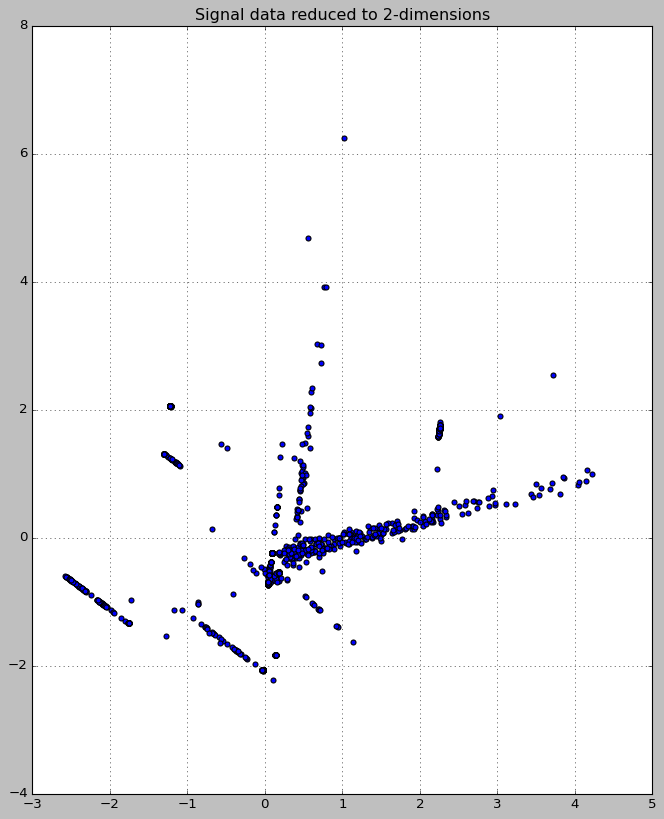

In [85]:
# scatter plot without colouring
plt.style.use('classic')
fig = plt.figure(figsize = (10,12))
plt.scatter(data = pca_data, y = 'PCA1', x = 'PCA2')
plt.title('Signal data reduced to 2-dimensions')
plt.grid(True)
plt.show()

There's some clustering to be found although it's not very clear due to lack of colours. We can, however, clearly see those two 'lines' in the bottom left corner as well as that one longer line from the center towards the right side. A few outliers can also be found.

Because clustering is an unsupervised learning method, the `class` column is completely unnecessary for most of these tasks. You will only need the `class` column in **Part 4**, where it's used to compute a performance metric and to visually compare clustering results to the classes.

### Part 2a: Agglomerative hierarchical clustering
 
 - Cluster the data into 4 clusters using agglomerative hierarchical clustering. Try different values for the "linkage" parameter.
 
 - Use the z-score standardized 6-dimensional data for clustering - not the principal components!
 
 - What is the significance of the linkage criterion in a hierarchical clustering algorithm?
 
 - Evaluate the clustering performance for each linkage criterion using a metric called "silhouette score".
 
 - What does silhouette score quantify and how is it computed?

### Part 2b: Dendrograms

 - Plot dendrograms to visualize the merging processes.
 - For this you will need a linkage matrix. Hint: while you can extract one from a fitted AgglomerativeClustering object, it is much easier to use the scipy implementation (scipy.cluster.hierarchy.linkage).
 - Compute the linkage matrix using both `average` and `complete` linkage, and plot the dendrograms using scipy.cluster.hierarchy.dendrogram).
 - Truncate the dendrogram so that three levels of the dendrogram tree are visible for better readability.
 - How do you interpret the dendrograms? How do they differ?

### Part 3: _k_-means clustering

 - Perform _k_-means clustering on the data. Use 4 clusters.
 - Evaluate the clustering performance using silhouette score.
 - Experiment with some other numbers of clusters. Does the data fit better into a different number of clusters according to silhouette score?

#### Rand score briefly described

Rand score is a measure of similarity between two partitions of a set of elements - in this case true classes and clusters found by the clustering algorithm - and it is one of the most frequently used performance metrics for clustering. It is computed by considering each pair of elements in the dataset and counting pairs of elements as follows:
 
         a: number of pairs such that the elements are in the same class and in the same cluster
         b: number of pairs such that the elements are in different classes and in different clusters
         c: number of pairs such that the elements are in the same class but in different clusters
         d: number of pairs such that the elements are in different classes but in the same cluster
     
     Given a, b, c, d, the formula for rand index is:
     
         rand_index = (a+b)/(a+b+c+d).
     
"Adjusted Rand index" is corrected for chance by using maximum and expected values of Rand index.

        adj_rand_index = (rand_index - expected_rand_index) / (max_rand_index - expected_rand_index)

###  Part 4a: Compare the clusters with the true labels (hierarchical clustering)
 
 - Cluster the data into 4 clusters using agglomerative hierarchical clustering.
 - Choose the linkage criterion that had the best silhouette score performance in Part 2a.
 - Visualize the data again using PCA, this time coloring the scatter plot based on the true class labels. Visually compare the two scatter plots: how well do the clusters found by the clustering algorithm match the true classes? Place the two scatter plots so that they can easily be compared (e.g. in subplots next to each other in the same figure).
 - For an objective evaluation of the clustering, compute the adjusted Rand score (use the scikit-learn implementation) using the true labels and the labels predicted by clustering algorithm. How do you interpret the result?
 - If the results seem unimpressive, don't get discouraged - clustering "real life" data sets to match classes is a difficult task, and a low Rand score does not necessarily mean that you have made a mistake.

### Part 4b: Compare the clusters with true labels (_k_-means clustering)

 - Repeat the above steps, but this time using _k_-means clustering instead of hierarchical clustering.
 - Which performs better according to the adjusted Rand score?

### Part 5 (optional BONUS task): Clustering unlabeled data

In this task, you are working with data where the classes are not available, given as `ex3_seeds_data_BONUS.csv` on Moodle. [The original data set](https://archive.ics.uci.edu/ml/datasets/seeds) is available for for those who are interested, but **use the slightly modified data on Moodle** instead.

In general this is a very challenging and open-ended type of task that requires in-depth domain knowledge for meaningful results. Note, however, that in this exercise you are **not required** to research the domain in question (e.g. properties of different varieties of wheat). You might need to search for more information related to clustering in order to complete this exercise.

Some of the questions are open-ended and have no correct answer. It's enough to clearly show that you thought about the questions.

 - As in Part 1, z-score standardize the data, project it to 2 dimensions using PCA and visualize the result in a scatter plot.
 - Does the scatter plot look like the data might have a clustered structure? How many clusters do you see?
 - Decide, based on what you've learned about silhouette score and Rand score, which performance metric you should use in this task. Justify your choice.
 - Get an objective evaluation of how many clusters the data most likely has by using your chosen performance metric. Try both _k_-means clustering and agglomerative hierarchical clustering with different linkage criterions and see which performs best.
 - Visualize (with color) the best-performing result in the PCA scatter plot you created earlier.